In [1]:
run '../__init__.py'

In [2]:
import numpy as np
import networkx as nx
import cvxpy as cp

# import warnings
# warnings.filterwarnings("ignore")

## Networkx Simple Example

In [3]:
G = nx.Graph()

In [4]:
G.add_nodes_from(['A', 'B', 'C', 'D', 'E'])

In [5]:
edges = [('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E')]
for e in edges:
    G.add_edge(*e)

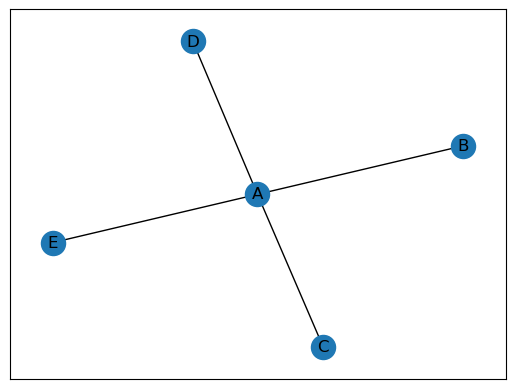

In [6]:
nx.draw_networkx(G)

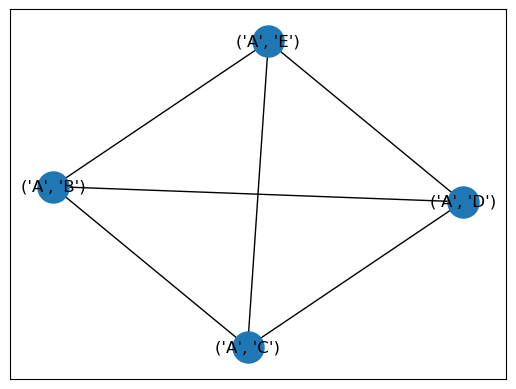

In [7]:
# Dual graph holy
G_prime=nx.line_graph(G)
nx.draw_networkx(G_prime, node_size=500)

In [8]:
L = nx.laplacian_matrix(G).todense()
L_prime = nx.laplacian_matrix(G_prime).todense()

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


## CVXPY

Minimize $$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2 + \lambda_1||\bar{F}L'F||_F + \lambda_2||FL'\bar{F}||_F + \lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F + \lambda_5||\bar{F} - F||_F$$
s.t.
1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [9]:
# F_in = np.random.randint(low=1, high=10, size=(4, 2))
F_in = np.array([[4, 8, 5],
                 [0, 0, 10],
                 [2, 0, 8],
                 [5, 2, 6]])
# F_out = np.random.randint(low=1, high=10, size=(4, 2))
F_out = np.array([[3, 2, 2],
                  [5, 7, 1],
                  [5, 0, 3],
                  [0, 5, 4]])
print(F_in.shape)

(4, 3)


In [10]:
omega_in = np.array([[1, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]])
omega_out = np.array([[1, 1, 1], [1, 1, 1], [1, 0, 1], [0, 1, 1]])

In [11]:
l1, l2, l3, l4, l5 = 1, 1, 1, 1, 1

In [12]:
F_in_c = cp.Variable((4, 3))
F_out_c = cp.Variable((4, 3))

In [13]:
# P = np.array([[1, 2],
#               [1, 1],
#               [4, 1],
#               [1, 1]])

P = cp.Variable((4, 3))

$$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2$$

In [14]:
expr1 = cp.square(cp.atoms.norm(cp.multiply(omega_in, (F_in - F_in_c)), p='fro'))
expr2 = cp.square(cp.atoms.norm(cp.multiply(omega_out, (F_out - F_out_c)), p='fro'))

$$\lambda_1||\bar{F}^\intercal L'F||_F + \lambda_2||F^\intercal L'\bar{F}||_F$$

In [15]:
expr3 = l1 * cp.atoms.norm(F_in.T @ L_prime @ F_out, p='fro')
expr4 = l2 * cp.atoms.norm(F_out.T @ L_prime @ F_in, p='fro')

$$\lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F$$

In [16]:
# expr5 = l3 * cp.atoms.norm(F_in - np.pad(F_in[:, 1:], pad_width=((0, 0),(0, 1))), p='fro')
# expr6 = l4 * cp.atoms.norm(F_out - np.pad(F_out[:, 1:], pad_width=((0, 0),(0, 1))), p='fro')

expr5 = l3 * cp.atoms.norm(F_in[:, 1:] - F_in[:, :-1], p='fro')
expr6 = l4 * cp.atoms.norm(F_out[:, 1:] - F_out[:, :-1], p='fro')

$$\lambda_5||\bar{F} - F||_F$$

In [17]:
expr7 = l5 * cp.atoms.norm(F_in - F_out, p='fro')

Constraint 1: $F_c, \bar{F_c} > 0$

In [18]:
# Define the constraints
constraints = [
    F_in_c >= 0,  # Ensure each element of F_in_c is positive
    F_out_c >= 0  # Ensure each element of F_out_c is positive
    # assert for Parking matrix to be positive
]

In [19]:
# P + np.pad(F_in_c.value[:, 1:], pad_width=((0, 0), (1, 0))) - np.pad(F_out_c.value[:, 1:], pad_width=((0, 0), (1, 0)))

Minimize

In [20]:
problem = cp.Problem(objective=cp.Minimize(expr1 + expr2 + expr3 + expr4 + expr5 + expr6 + expr7),
                     constraints=constraints)
problem.solve()

241.1573292502305

In [30]:
F_in_c.value

array([[ 4.        ,  8.00000001,  5.        ],
       [ 4.08111222,  4.08111222, 10.00000001],
       [ 2.        ,  4.08111222,  8.00000001],
       [ 5.        ,  2.        ,  6.00000001]])

In [31]:
F_out_c.value

array([[3.00000006, 2.00000009, 2.00000009],
       [5.        , 6.99999998, 1.00000007],
       [5.        , 4.08111222, 3.00000006],
       [4.08111222, 5.        , 4.00000003]])

In [33]:
F_in_c.value - F_out_c.value

array([[ 0.99999994,  5.99999992,  2.99999991],
       [-0.91888778, -2.91888776,  8.99999995],
       [-3.00000001,  0.        ,  4.99999995],
       [ 0.91888778, -3.00000001,  1.99999998]])